In [1]:
import torch
import numpy as np
import os

from sklearn.metrics import confusion_matrix
from utils import get_ecg, qrs_detection, get_segments, plot, plot_confusion_matrix
from data import build_dataloader
from train import learn, cnn_feed_lstm

In [2]:
PATH = "/Users/nguyenvietthai/Downloads/training2017"
BATCH_SIZE = 2048
EPOCH = 50
FS = 300
LENGTH = 9000
LR = 1e-3
RESAMP = False

In [3]:
try:
    segments = np.load('/Users/nguyenvietthai/Downloads/training2017/segment.npy')
except:
    signals, labels = get_ecg(PATH, length=LENGTH)
    segments = np.zeros((245990, 1001))
    k = 0
    
    for i, record in enumerate(signals):
        print("running",i)
        rp = qrs_detection(record, sample_rate=FS)
        seg = get_segments(record, rp, labels[i])
        if seg is not None:
            segments[k:k+seg.shape[0], :] = seg
            k += seg.shape[0]
    del signals, labels
    
    np.save('/Users/nguyenvietthai/Downloads/training2017/segment.npy', segments)

In [4]:
X, y = segments[:, :-1], segments[:, -1][:, np.newaxis]
del segments

train, test = build_dataloader(X, y, resamp=RESAMP, batch_size=BATCH_SIZE)
del X, y

net = cnn_feed_lstm()
try:
    params = torch.load("../params/net_0.81.pkl")
    net.load_state_dict(params["model_state_dict"])
except:
    pass

Start building dataloader.


Start training.
Epoch:  1  | Loss: 0.684  | F1 Score: 0.74
              precision    recall  f1-score   support

        aFib       0.70      0.50      0.58      3997
      Normal       0.77      0.92      0.84     20943
      Others       0.66      0.50      0.57     11959

    accuracy                           0.74     36899
   macro avg       0.71      0.64      0.66     36899
weighted avg       0.73      0.74      0.72     36899

Epoch:  2  | Loss: 0.665  | F1 Score: 0.75
              precision    recall  f1-score   support

        aFib       0.72      0.59      0.65      3997
      Normal       0.77      0.93      0.84     20943
      Others       0.72      0.49      0.58     11959

    accuracy                           0.75     36899
   macro avg       0.74      0.67      0.69     36899
weighted avg       0.75      0.75      0.74     36899

Epoch:  3  | Loss: 0.614  | F1 Score: 0.76
              precision    recall  f1-score   support

        aFib       0.77      0.58     

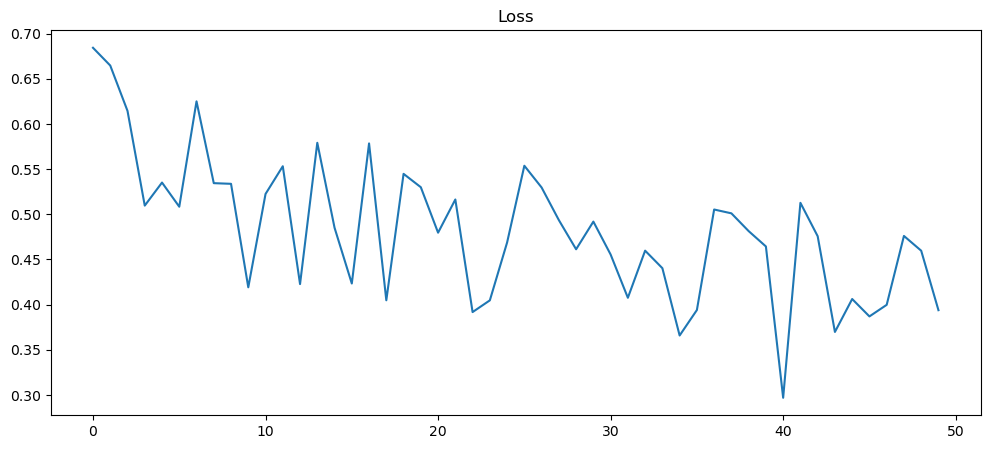

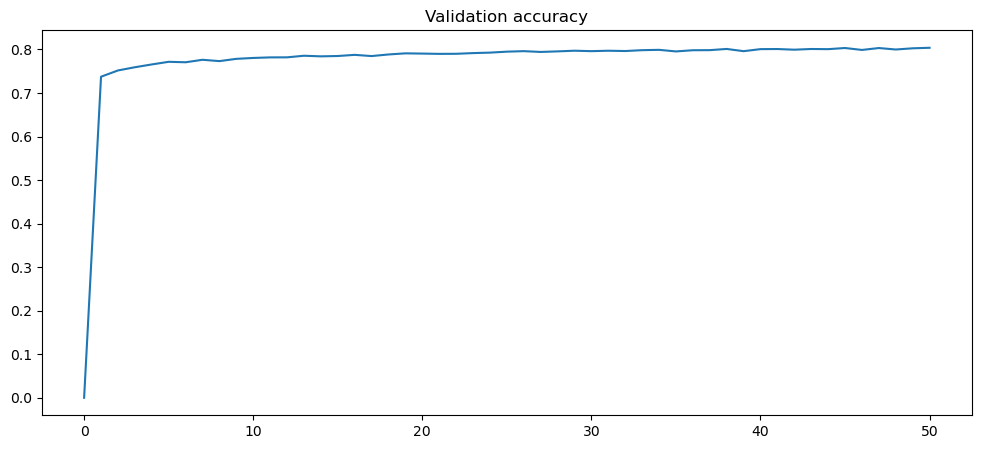

In [5]:
loss, val_score, predictions, true_labels = learn(net, train, test, lr=LR, epoch=EPOCH)
plot(loss, val_score)

Confusion matrix, without normalization


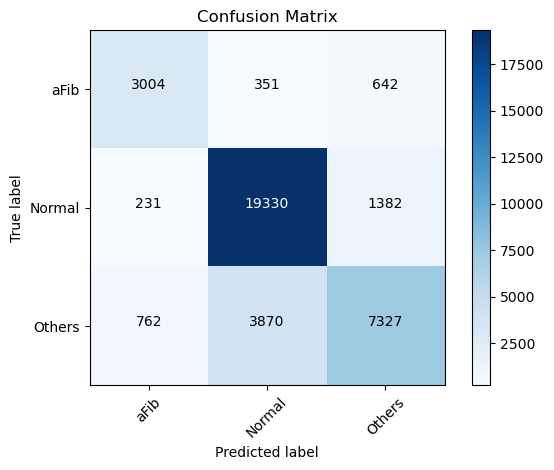

In [6]:
cm = confusion_matrix(true_labels,predictions)
classes = ['aFib','Normal','Others']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix')